# Live Birth Occurrence

In [1]:
library("tidyverse")
library("tidymodels")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”Warning message:
“package ‘tidyr’ was built under R version 3.6.2”Warning message:
“package ‘dplyr’ was built under R version 3.6.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘tidymodels’ was built under R version 3.6.2”── Attaching packages ────────────────────────────────────── tidymodels 0.1.0 ──
✔ broom     0.5.5          ✔ rsample   0.0.5     
✔ dials     0.0.4          ✔ tune      0.0.1.9000
✔ infer     0.5.1          ✔ workflows 0.1.1     
✔ parsnip   0.0.5   

## Raw data

In [2]:
ivf_raw = data.table::fread("data/hfea-ivf.csv")
ivf_raw %>% glimpse(width = 120)

Observations: 1,376,454
Variables: 96
$ `Patient Age at Treatment`                                                 <chr> "18 - 34", "35-37", "18 - 34", "38…
$ `Date patient started trying to become pregnant OR date of last pregnancy` <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ `Total Number of Previous cycles, Both IVF and DI`                         <chr> "1", "0", "0", "1", "0", "1", "0",…
$ `Total Number of Previous treatments, Both IVF and DI at clinic`           <chr> "1", "0", "0", "1", "0", "1", "0",…
$ `Total Number of Previous IVF cycles`                                      <chr> "0", "0", "0", "0", "0", "0", "0",…
$ `Total Number of Previous DI cycles`                                       <chr> "1", "0", "0", "1", "0", "1", "0",…
$ `Total number of previous pregnancies, Both IVF and DI`                    <chr> "0", "0", "0", "0", "0", "0", "0",…
$ `Total number of IVF pregnancies`                                          <chr> "0", "0", "0", "0", "0", "0", "0",…
$ `Total n

## cleaning

In [3]:
transform_specific_treatment = function(x) {
    # Marina's solution
    x %>% str_replace_all(" / ", ":") %>%
    str_replace_all("\\+", ":") %>%
    str_replace_all(":Unknown", "") %>%
    str_replace_all(" ", "") %>%
    if_else(is.na(.), "Unknown", .)
}

In [4]:
# step1
# Remove pre-2000 
# Specific treatment
ivf_step1 = ivf_raw %>%
    filter(`Year of Treatment` > 2000) %>%
    mutate(
        specific_treatment=`Specific treatment type` %>% transform_specific_treatment() %>%
        str_split(":"),
        # super ivf treatment
        treatment_ivf_ivf=specific_treatment %>% 
            map_lgl(function(x) "IVF" %in% x),
        treatment_ivf_icsi=specific_treatment %>% 
            map_lgl(function(x) "ICSI" %in% x),
        treatment_ivf_unknown=specific_treatment %>% 
            map_lgl(function(x) "Unknown" %in% x),
        # super di treatment
        treatment_di_ici=specific_treatment %>%
            map_lgl(function(x) "ICI" %in% x),
        treatment_di_iui=specific_treatment %>%
            map_lgl(function(x) "IUI" %in% x)
    ) %>%
    mutate_at(
        vars(treatment_ivf_ivf, treatment_ivf_icsi, treatment_ivf_unknown,
             treatment_di_ici, treatment_di_iui),
        as.integer
    ) %>%
    select(-specific_treatment)
ivf_step1 %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             943599    
Number of columns          101       
_______________________              
Column type frequency:               
  character                47        
  logical                  1         
  numeric                  53        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable                                                  n_missing
 1 Patient Age at Treatment                                               0
 2 Total Number of Previous cycles, Both IVF and DI                       0
 3 Total Number of Previous treatments, Both IVF and DI at clinic         0
 4 Total Number of Previous IVF cycles                                    0
 5 Total Number of Previous DI cycles                                     0
 6 

In [40]:
# step2
# - remove variables that 
#   - contain too many missing rows
#   - contain too many "" rows
# - reformat variable names
ivf_step2 = ivf_step1 %>%
    rename(live_birth_occurr=`Live Birth Occurrence`) %>%
    mutate_at(vars(live_birth_occurr), 
              function(x) if_else(is.na(x), 0L, 1L) %>% as_factor()) %>%
    select_if(
        function(x) {
            ratio = sum(is.na(x)) / length(x)
            ratio < 0.1
        }
    ) %>%
    select_if(
        function(x) {
            p = TRUE
            if (is.character(x)) {
                ratio = sum(x == "", na.rm=TRUE) / length(x)
                p = ratio < 0.2
            }
            p
        }
    ) %>%
    {
        df = .
        names(df) = names(df) %>% 
            str_replace_all(" ", "_") %>% 
            str_replace_all("-", "_") %>% 
            str_replace_all(",", "_") %>% 
            str_replace_all("\\(", "_") %>% 
            str_replace_all("\\)", "_") %>% 
            str_to_lower()
        df
    }
ivf_step2 %>% count(live_birth_occurr)
ivf_step2 %>% skimr::skim()

live_birth_occurr,n
0,730940
1,212659


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             943599    
Number of columns          65        
_______________________              
Column type frequency:               
  character                28        
  factor                   1         
  numeric                  36        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable                                                  n_missing
 1 patient_age_at_treatment                                               0
 2 total_number_of_previous_cycles__both_ivf_and_di                       0
 3 total_number_of_previous_treatments__both_ivf_and_di_at_clinic         0
 4 total_number_of_previous_ivf_cycles                                    0
 5 total_number_of_previous_di_cycles                                     0
 6 

In [21]:
names = ivf_step2 %>% select_if(is.character) %>% names()
for (name in names) {
    cat("\n", name, "\n")
    tibble(variable=ivf_step2[[name]]) %>% count(variable) %>% print()
}


 patient_age_at_treatment 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 18 - 34  403776
2 35-37    218312
3 38-39    137480
4 40-42    121994
5 43-44     33702
6 45-50     18094
7 999       10241

 total_number_of_previous_cycles__both_ivf_and_di 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       52311
2 0        377741
3 1        229043
4 2        134610
5 3         76916
6 4         45389
7 5         27589

 total_number_of_previous_treatments__both_ivf_and_di_at_clinic 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       30843
2 0        438202
3 1        236948
4 2        122856
5 3         62520
6 4         33405
7 5         18825

 total_number_of_previous_ivf_cycles 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       29859
2 0        437537
3 1        220938
4 2        126014
5 3         69151
6 4         38403
7 5         21697

 total_number_of_previous_di_cycles 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >

In [42]:
# step3
# - for some vars, select first item in "," delim list
# - for some string vars, combine "2.0" with "2"
# - remove vars with no variation
ivf_step3 = ivf_step2 %>%
    mutate_at(
        vars(main_reason_for_producing_embroys_storing_eggs, early_outcome),
        function(x) 
            x %>% 
            str_split(",") %>% 
            map_chr(function(x) x[[1]]) %>% 
            str_trim()
    ) %>%
    mutate_if(
        is.character,
        function(x) 
            x %>% str_remove("\\.0$")
    ) %>%
    filter_at(vars(patient_age_at_treatment), function(x) x != "999") %>%
    select_if(function(x) {
        p = TRUE
        if ((is.numeric(x)) && (sd(na.omit(x)) == 0)) {
            p = FALSE
        }
        p
    })
ivf_step3 %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             933358    
Number of columns          65        
_______________________              
Column type frequency:               
  character                28        
  factor                   1         
  numeric                  36        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable                                                  n_missing
 1 patient_age_at_treatment                                               0
 2 total_number_of_previous_cycles__both_ivf_and_di                       0
 3 total_number_of_previous_treatments__both_ivf_and_di_at_clinic         0
 4 total_number_of_previous_ivf_cycles                                    0
 5 total_number_of_previous_di_cycles                                     0
 6 

In [43]:
names = ivf_step3 %>% select_if(is.character) %>% names()
for (name in names) {
    cat("\n", name, "\n")
    tibble(variable=ivf_step3[[name]]) %>% count(variable) %>% print()
}


 patient_age_at_treatment 
# A tibble: 6 x 2
  variable      n
  <chr>     <int>
1 18 - 34  403776
2 35-37    218312
3 38-39    137480
4 40-42    121994
5 43-44     33702
6 45-50     18094

 total_number_of_previous_cycles__both_ivf_and_di 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       52284
2 0        369925
3 1        227383
4 2        134152
5 3         76749
6 4         45314
7 5         27551

 total_number_of_previous_treatments__both_ivf_and_di_at_clinic 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       30816
2 0        430386
3 1        235288
4 2        122398
5 3         62353
6 4         33330
7 5         18787

 total_number_of_previous_ivf_cycles 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       29832
2 0        429721
3 1        219278
4 2        125556
5 3         68984
6 4         38328
7 5         21659

 total_number_of_previous_di_cycles 
# A tibble: 7 x 2
  variable      n
  <chr>     <int>
1 >=5       17997
2 0

In [68]:
# remove vars that violate domain knowledge
ivf_df = ivf_step3 %>%
    select(-`number_of_live_births`, -`early_outcome`) %>%
    select(-contains("foetal"))
ivf_df %>% skimr::skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             933358    
Number of columns          62        
_______________________              
Column type frequency:               
  character                27        
  factor                   1         
  numeric                  34        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable                                                  n_missing
 1 patient_age_at_treatment                                               0
 2 total_number_of_previous_cycles__both_ivf_and_di                       0
 3 total_number_of_previous_treatments__both_ivf_and_di_at_clinic         0
 4 total_number_of_previous_ivf_cycles                                    0
 5 total_number_of_previous_di_cycles                                     0
 6 

## Preprocessing

In [69]:
ivf_df %>% write_rds("birth_ivf_cleaned.rds")
ivf_df %>% write_csv("birth_ivf_cleaned.csv")

In [61]:
ivf_split = ivf_df %>% initial_split(prop=0.8)

In [62]:
proc_rules <- recipe(live_birth_occurr ~ ., data=ivf_split %>% training()) %>% 
    # resample
    step_downsample(live_birth_occurr) %>%
    # transformation
    step_other(all_nominal(), -all_outcomes()) %>%
    step_string2factor(all_nominal()) %>%
    step_dummy(all_nominal(), -all_outcomes()) %>%
    # auto trim
    step_naomit(all_predictors()) %>%
    # step_corr(all_numeric()) %>%
    # step_lincomb(all_numeric()) %>%
    step_nzv(all_numeric())
proc_rules

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         61

Operations:

Down-sampling based on live_birth_occurr
Collapsing factor levels for all_nominal, -, all_outcomes()
Factor variables from all_nominal
Dummy variables from all_nominal, -, all_outcomes()
Removing rows with NA values in all_predictors
Sparse, unbalanced variable filter on all_numeric

In [63]:
proc_rules_prep = proc_rules %>% prep()
training_df = proc_rules_prep %>% juice()
testing_df = proc_rules_prep %>% bake(new_data=ivf_split %>% testing())

## Modelling

In [64]:
model = boost_tree(mode="classification", trees=50) %>%
    set_engine("xgboost")
model_fit = model %>% fit(live_birth_occurr ~ ., data=training_df)
model_fit

parsnip model object

Fit time:  1m 14.1s 
##### xgb.Booster
raw: 198.8 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, min_child_weight = 1, subsample = 1), 
    data = x, nrounds = 50, verbose = 0, objective = "binary:logistic", 
    nthread = 1)
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", min_child_weight = "1", subsample = "1", objective = "binary:logistic", nthread = "1", silent = "1"
xgb.attributes:
  niter
# of features: 86 
niter: 50
nfeatures : 86 

# A tibble: 3 x 3
  .metric  .estimator .estimate
  <chr>    <chr>          <dbl>
1 accuracy binary         0.589
2 kap      binary         0.224
3 roc_auc  binary         0.662


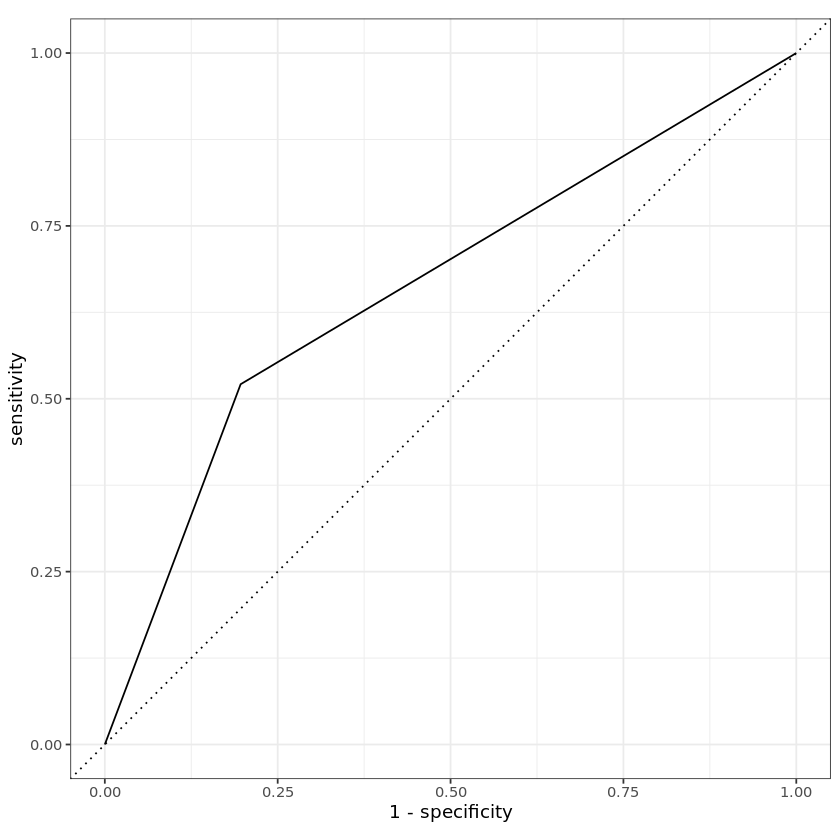

In [76]:
model_pred = model_fit %>% predict(testing_df)

pred_df = model_pred %>% bind_cols(testing_df)
pred_df %>%
    metrics(truth=live_birth_occurr, estimate=.pred_class) %>%
    bind_rows(
        pred_df %>%
            mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
            roc_auc(., live_birth_occurr, .pred_class)
    ) %>% print()

pred_df %>%
    mutate_at(vars(.pred_class), function(x) as.integer(as.character(x))) %>%
    roc_curve(., live_birth_occurr, .pred_class) %>%
    autoplot()

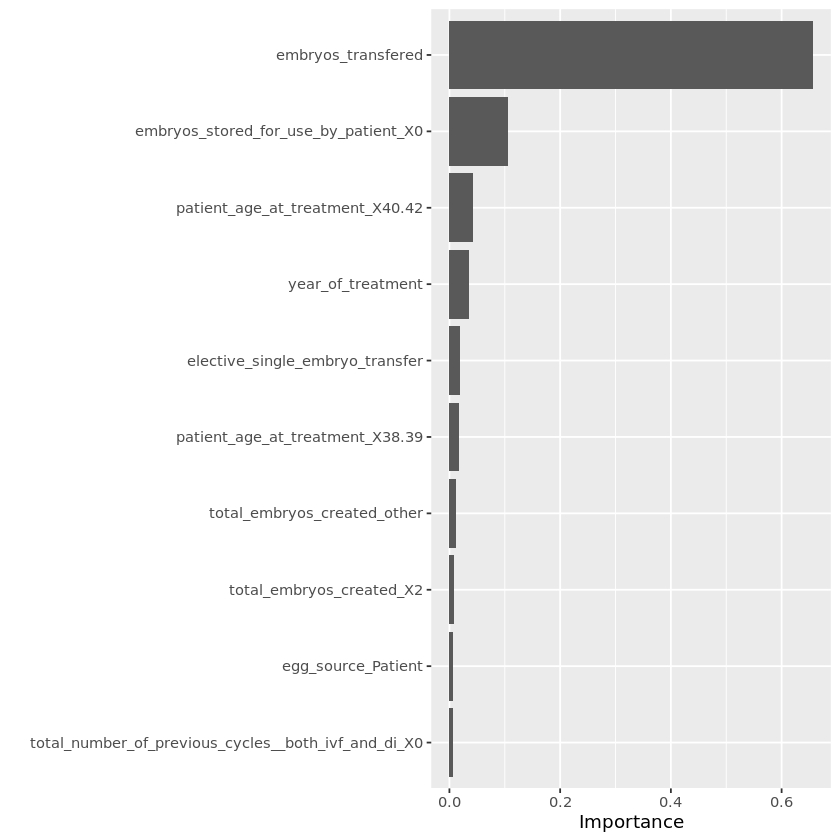

In [67]:
vip::vip(model_fit)